In [98]:
import pandas as pd
import numpy as np
import math
from openpyxl import load_workbook
from openpyxl.utils import get_column_letter
from openpyxl.styles import PatternFill, Alignment
import statistics
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from PIL import Image
import tempfile

Settings

In [99]:
FILE_NAME = "data.xlsx" #don't touch
IMAGE_PATH = "image.png"
TIME_INCREMENT = 5.08 # Should be this for all images
SIZE_OF_INCLUSION = 0.00 #change size of inclusion
IMAGE_NAME = "1K_OA_13" #change to the file name
IS_3K = False #IF you are doing a 1K or WT make this value False but if it is a 3K make it True
analysis_path   = f"{IMAGE_PATH}_analysis.xlsx"
fit_curve_path  = f"{IMAGE_PATH}_fit_curve.xlsx"

Sub Functions

In [100]:
def truncate(x, decimals):
    if isinstance(x, float):
        factor = 10 ** decimals
        return math.trunc(x * factor) / factor
    return x

def avg(ws, col, start_row, end_row):
    values = [ws[f"{col}{row}"].value for row in range(start_row, end_row + 1)]
    values = [v for v in values if isinstance(v, (int, float))]
    return statistics.mean(values) if values else None

def save_all_to_jpg(figs, image_path, output_jpg):
    # 1) Render each Matplotlib Figure to a temporary PNG
    temp_paths = []
    for fig in figs:
        tmp = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
        fig.savefig(tmp.name, dpi=300, bbox_inches="tight")
        temp_paths.append(tmp.name)
        plt.close(fig)

    # 2) Add the inclusion image last
    temp_paths.append(image_path)

    # 3) Open all images and measure total size
    images = [Image.open(p) for p in temp_paths]
    widths, heights = zip(*(im.size for im in images))
    
    max_width = max(widths)
    total_height = sum(heights)
    
    # 4) Create a blank canvas and paste each image centered
    canvas = Image.new("RGB", (max_width, total_height), (255,255,255))
    y_offset = 0
    for im in images:
        x_offset = (max_width - im.width) // 2
        canvas.paste(im, (x_offset, y_offset))
        y_offset += im.height
    
    # 5) Save the combined canvas as a single JPEG
    canvas.save(output_jpg, "JPEG", quality=95)
    return output_jpg

Clean Data

In [101]:
df = pd.read_excel(FILE_NAME)

analysis = df.iloc[:, :3].copy()

analysis.iloc[:, 0] = analysis.iloc[:, 0].apply(lambda x: truncate(x, 2))
analysis.iloc[:, 1] = analysis.iloc[:, 1].apply(lambda x: truncate(x, 2))
analysis.iloc[:, 2] = analysis.iloc[:, 2].apply(lambda x: truncate(x, 2))

print(analysis)

    Intensity Mean Value 1  Intensity Mean Value 2  Intensity Mean Value 3
0                    24.19                   17.01                    3.01
1                    24.48                   15.98                    2.87
2                    23.97                   16.09                    3.16
3                     8.97                   15.61                    3.21
4                    11.92                   14.70                    2.62
5                    12.62                   14.78                    2.60
6                    12.94                   14.79                    2.50
7                    13.13                   14.46                    3.08
8                    13.03                   14.52                    2.65
9                    12.93                   14.16                    2.68
10                   12.96                   13.71                    2.09
11                   13.13                   14.14                    2.06
12                   12.9

In [102]:
analysis['cycle'] = list(range(1, len(analysis) + 1))

# Reorder so 'cycle' is the first column
analysis = analysis[['cycle'] + [col for col in analysis.columns if col != 'cycle']]

cols = analysis.columns.tolist()

cols[1] = 'ROI1'
cols[2] = 'ROI2'
cols[3] = 'ROI3'

analysis.columns = cols

num_rows = len(analysis)
time_column = [round((i + 1) * TIME_INCREMENT, 2) for i in range(num_rows)]

analysis["TIME (sec)"] = time_column

analysis.insert(5, 'ROI1 ', [None] * num_rows)
analysis.insert(6, 'ROI2 ', [None] * num_rows)
analysis.insert(7, 'ROI3 ', [None] * num_rows)

analysis.to_excel(f"{IMAGE_NAME}_analysis.xlsx", index=False)

In [103]:
# Load the existing workbook and worksheet
wb = load_workbook(f"{IMAGE_NAME}_analysis.xlsx")
ws = wb.active  # or wb['SheetName'] if named

red_accent_fill = PatternFill(start_color="F4CCCC", end_color="F4CCCC", fill_type="solid")
orange_accent_fill = PatternFill(start_color="FCE5CD", end_color="FCE5CD", fill_type="solid")
aqua_accent_fill = PatternFill(start_color="B7DEE8", end_color="B7DEE8", fill_type="solid")
dark_blue_accent_fill = PatternFill(start_color="00B0F0", end_color="00B0F0", fill_type="solid")
purple_accent_fill = PatternFill(start_color="CCC0DA", end_color="CCC0DA", fill_type="solid")
light_pink_accent_fill = PatternFill(start_color="DA9694", end_color="DA9694", fill_type="solid")
light_brown_accent_fill = PatternFill(start_color="C4BD97", end_color="C4BD97", fill_type="solid")
light_green_accent_fill = PatternFill(start_color="EBF1DE", end_color="EBF1DE", fill_type="solid")
blue_accent_fill = PatternFill(start_color="538DD5", end_color="538DD5", fill_type="solid")


# Manual calculations
if IS_3K:
    f6 = avg(ws, "B", 2, 6)
    g6 = avg(ws, "C", 2, 6)
    h6 = avg(ws, "D", 2, 6)
    g7 = avg(ws, "C", 7, 41)
else:
    f6 = avg(ws, "B", 2, 4)
    g6 = avg(ws, "C", 2, 4)
    h6 = avg(ws, "D", 2, 4)
    g7 = avg(ws, "C", 5, 41)
j7 = g7 / g6 if g6 else None

# Assign static labels
if IS_3K:
    ws["I6"] = "AVERAGE 5 images before bleaching"
else:
    ws["I6"] = "AVERAGE 3 images before bleaching"
ws["I7"] = "AVERAGE all images after bleaching"
ws["J6"] = "r RO2"
ws["K1"] = "normalized F ROI1"
ws["L6"] = "plateau best fit value (prism)"
ws["M6"] = "mobile fraction Fm"
ws["N6"] = "immobile fraction Fi"
ws["O6"] = "size of inclusion"
ws["P6"] = "average normalized F ROI1 before bleaching"

# Assign computed values
ws["F6"] = f6
ws["G6"] = g6
ws["H6"] = h6
ws["G7"] = g7
ws["J7"] = j7
ws["O7"] = SIZE_OF_INCLUSION

# Compute normalized F ROI1 manually in K2:K{end}
for row in range(2, ws.max_row + 1):
    b = ws[f"B{row}"].value
    d = ws[f"D{row}"].value
    if isinstance(b, (int, float)) and isinstance(d, (int, float)) and j7:
        ws[f"K{row}"] = (b - d) / j7
    else:
        ws[f"K{row}"] = None

if IS_3K:
    p7 = avg(ws, "K", 2, 6)
else:
    p7 = avg(ws, "K", 2, 4)
ws["P7"] = p7


for cell in ["F6", "G6", "H6", "I6"]:
    ws[cell].fill = red_accent_fill

for cell in ["G7", "H7", "I7"]:
    ws[cell].fill = orange_accent_fill  

for cell in ["J6", "J7"]:
    ws[cell].fill = aqua_accent_fill

for cell in ["L6", "L7"]:
    ws[cell].fill = purple_accent_fill

for cell in ["M6", "M7"]:
    ws[cell].fill = light_pink_accent_fill

for cell in ["N6", "N7"]:
    ws[cell].fill = light_brown_accent_fill

for cell in ["O6", "O7"]:
    ws[cell].fill = light_green_accent_fill

for cell in ["P6", "P7"]:
    ws[cell].fill = blue_accent_fill

for row in range(1, ws.max_row + 1):
    ws[f"K{row}"].fill = dark_blue_accent_fill
    
ws.row_dimensions[6].height = 57
ws.column_dimensions["I"].width = 16
ws.column_dimensions["L"].width = 12.57
ws.column_dimensions["P"].width = 11.14


ws["I6"].alignment = Alignment(wrap_text=True)
ws["I7"].alignment = Alignment(wrap_text=True)
ws["L6"].alignment = Alignment(wrap_text=True)
ws["M6"].alignment = Alignment(wrap_text=True)
ws["N6"].alignment = Alignment(wrap_text=True)
ws["O6"].alignment = Alignment(wrap_text=True)
ws["P6"].alignment = Alignment(wrap_text=True)

column_indices = [1, 2, 3, 4, 5, 11]

for col_idx in column_indices:
    col_letter = get_column_letter(col_idx)
    max_length = 0
    for cell in ws[col_letter]:
        if cell.value:
            max_length = max(max_length, len(str(cell.value)))
    
    ws.column_dimensions[col_letter].width = max_length + 2  # Add some padding

wb.save(f"{IMAGE_NAME}_analysis.xlsx")


Fit Exponential Model

In [104]:
# Read the Excel file (assumes values already calculated in Excel)
df = pd.read_excel(f"{IMAGE_NAME}_analysis.xlsx")

if (IS_3K):
    x = df.iloc[5:, 4].values   # Column E is index 4
    y = df.iloc[5:, 10].values  # Column K is index 10
else:
    x = df.iloc[3:, 4].values
    y = df.iloc[3:, 10].values  # Column J is index 9

def exp_plateau_fixed_y0(x, YM, k):
    return YM * (1 - np.exp(-k * x))

# Fit the model
popt, _ = curve_fit(exp_plateau_fixed_y0, x, y, p0=[max(y), 0.01], bounds=([0, 1e-8], [np.inf, np.inf]))
YM, k = popt

plateu = YM
plateu = round(plateu, 2)
print(f"Plateau value (YM): {plateu}")

Plateau value (YM): 12.67


In [105]:
wb = load_workbook(f"{IMAGE_NAME}_analysis.xlsx")
ws = wb.active 

# Write the plateau value to the worksheet
ws["L7"] = plateu
m7 = plateu / p7 
n7 = 1 - m7 
ws["M7"] = m7
ws["N7"] = n7

wb.save(f"{IMAGE_NAME}_analysis.xlsx")

column_e = df.iloc[:, 4].dropna()

time_frame = column_e.iloc[-1]

Fit Curve Excel

In [106]:
x_generated = np.linspace(0, time_frame, 1000)
y_generated = exp_plateau_fixed_y0(x_generated, YM, k)

# Create DataFrame and write to Excel
fit_df = pd.DataFrame({
    "Time (sec)": x_generated,
    "Fluorescence intensity": y_generated, 
    "Fluorescence intensity (percentage)": (y_generated * 100) / p7
})


fit_df.to_excel(f"{IMAGE_NAME}_fit_curve.xlsx", index=False)

Generate Graphs

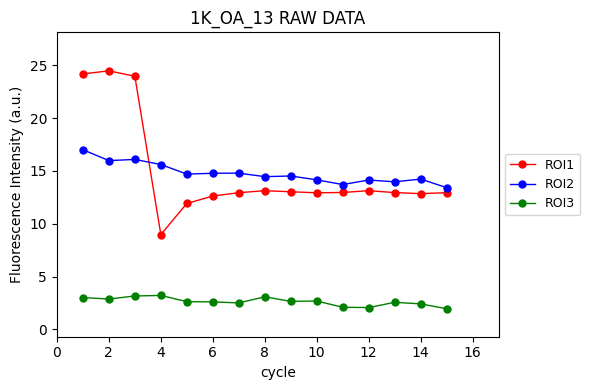

In [107]:
df = pd.read_excel(f"{IMAGE_NAME}_analysis.xlsx")

df["cycle"] = pd.to_numeric(df["cycle"], errors="coerce")
df["ROI1"]  = pd.to_numeric(df["ROI1"],  errors="coerce")
df["ROI2"]  = pd.to_numeric(df["ROI2"],  errors="coerce")
df["ROI3"]  = pd.to_numeric(df["ROI3"],  errors="coerce")

df = df.iloc[:, :4]
df.columns = ["cycle", "ROI1", "ROI2", "ROI3"]

# 1) RAW DATA
fig1 = plt.figure(figsize=(6,4))
ax1  = fig1.subplots()
x_vals = df["cycle"].to_numpy(dtype=float)
y1     = df["ROI1"].to_numpy(dtype=float)
y2     = df["ROI2"].to_numpy(dtype=float)
y3     = df["ROI3"].to_numpy(dtype=float)
ax1.plot(x_vals, y1, 'o-', label="ROI1", color="red", linewidth=1, markersize=5)
ax1.plot(x_vals, y2, 'o-', label="ROI2", color="blue", linewidth=1, markersize=5)
ax1.plot(x_vals, y3, 'o-', label="ROI3", color="green", linewidth=1, markersize=5)
ax1.set(xlabel="cycle", ylabel="Fluorescence Intensity (a.u.)",
        title=f"{IMAGE_NAME} RAW DATA",
        xlim=(0, x_vals.max()+2),
        ylim=(-0.7, max(y1.max(),y2.max(),y3.max())*1.15))
ax1.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=9)
fig1.tight_layout()

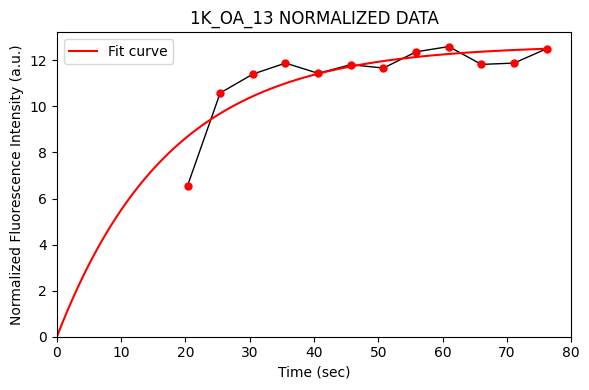

In [108]:
# 2) NORMALIZED DATA
fig2 = plt.figure(figsize=(6,4))
ax2  = fig2.subplots()
ax2.plot(x, y, '-', color='black', linewidth=1)
ax2.plot(x, y, 'o', color='red', markersize=5)
ax2.plot(x_generated, y_generated, '-', color='red', label='Fit curve')
ax2.set(xlabel="Time (sec)", ylabel="Normalized Fluorescence Intensity (a.u.)",
        title=f"{IMAGE_NAME} NORMALIZED DATA")
ax2.set(xlim=(0,None), ylim=(0,None))
ax2.legend()
fig2.tight_layout()

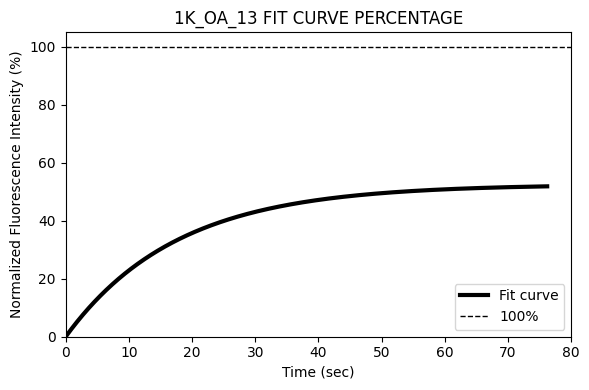

In [109]:
# 3) FIT CURVE PERCENTAGE
fig3 = plt.figure(figsize=(6,4))
ax3  = fig3.subplots()
ax3.plot(x_generated, fit_df["Fluorescence intensity (percentage)"],
         '-', color='black', linewidth=3, label='Fit curve')
ax3.axhline(100, linestyle='--', color ='black', linewidth=1, label='100%')
ax3.set(xlabel="Time (sec)", ylabel="Normalized Fluorescence Intensity (%)",
        title=f"{IMAGE_NAME} FIT CURVE PERCENTAGE")
ax3.set(xlim=(0,None), ylim=(0,None))
ax3.legend()
fig3.tight_layout()

Generate JPG_FILE

In [110]:
jpg_file = save_all_to_jpg([fig1, fig2, fig3], IMAGE_PATH, f"{IMAGE_NAME}_complete.jpg")